# PROYECTO MÓDULO I. TITANIC

## Andrea Martínez García
18/11/2023

#### A continuación, haciendo uso de una parte de los datos de esta tragedia, teniendo en cuenta que contamos solo con la información de 891 pasajeros,  vamos a analizar la posible relación entre los supervivientes y otros factores que pudieron ser determinantes en el resultado final de este famoso acontecimiento.

##### ** Carga de librerias **

In [2]:
# Tratamiento del dataset
import numpy as np
import pandas as pd
import os

# Análisis y predicción
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


# librerías para gráficas
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px



##### ** Carga del dataset **

In [37]:
ruta_archivo = 'C:/Users/Andrea/Desktop/BOOTCAMP/Bootcamp/modulo I/13. Ejercicios proyecto módulo I/titanic.csv'

In [38]:
os.path.exists('C:/Users/Andrea/Desktop/BOOTCAMP/Bootcamp/modulo I/13. Ejercicios proyecto módulo I/titanic.csv')
titanic_data = pd.read_csv('C:/Users/Andrea/Desktop/BOOTCAMP/Bootcamp/modulo I/13. Ejercicios proyecto módulo I/titanic.csv')

In [39]:
# Vemos el aspecto de nuesto dataset

titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
titanic_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [41]:
# Buscamos si hay objetos nulos
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


##### ** Limpieza de datos **

In [42]:
# Verificamos el total de valores faltantes
print(pd.isnull(titanic_data).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [43]:
# Hacemos copia para no modificar el dataframe original
df = titanic_data.copy()

In [44]:
# Como en la columna Cabin hay excesivos datos faltantes, vamos a reemplazarlos por "Sin datos"
df['Cabin'].fillna('Sin datos', inplace=True)

In [45]:
# Convertimos la columna embarque en datos numéricos para su procesamiento
df['Embarked'].replace(['Q', 'S', 'C'], [0,1,2], inplace=True)


In [46]:
# La columna edad tiene excesivos datos faltantes por lo que vamos a sustituirlos por el algoritmo KNN, es decir, por los elementos similares más cercanos de mi conjunto de datos.
# Creamos la columna lastname para guardar el apellido de los pasajeros
df['LastName'] = df['Name'].apply(lambda x: x.split(',')[0])

In [47]:
# Creo una copia de la columna 'Fare' para su posterior comparación
original_fare = df['Fare'].copy()

# Vamos a normalizar Fare para encontrar el mejor valor de KNN
scaler = StandardScaler()
df['Fare_normalized'] = scaler.fit_transform(df[['Fare']])


# Restaurar los valores originales a la columna 'Fare' (para que no me cambie los valores en mi dataframe)
df['Fare'] = original_fare

In [48]:
# Estas son las columnas que necesitamos como predictores para el modelo
columnas=['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked',"Age"]

# Aplicamos OneHotEncoder para codificar nuestras variables categóricas 
encoder = OneHotEncoder(drop='first', sparse=False)
df_encoded = pd.DataFrame(encoder.fit_transform(df[columnas]))
df_encoded.columns = encoder.get_feature_names_out(columnas)

c:\Users\Andrea\Desktop\BOOTCAMP\mi_entorno\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [49]:
# Creamos dos dataframes basados en la presencia de Age
df_encoded['Age'] = df['Age']
df_with_age = df_encoded.dropna(subset=['Age'])
df_without_age = df_encoded[df_encoded['Age'].isna()].drop(columns='Age')

In [50]:
# Dividimos el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(df_with_age.drop(columns='Age'), df_with_age['Age'], test_size=0.2, random_state=357)

scores = [218.2927513  125.86622807 215.89001228 143.58794123 171.37039737]
scores = [136.86255087  84.91899671 158.71497763  99.91052281 125.93988509]
scores = [129.84448831  58.9978     137.6253808  109.4653537  120.18960439]
scores = [125.37341315  68.35092396 128.94322122 110.75573202 134.69403712]
scores = [128.50304581  74.55439933 131.75326298 124.03689972 136.21150926]
scores = [139.78911524  81.90900268 132.9866682  134.74493872 141.1186662 ]


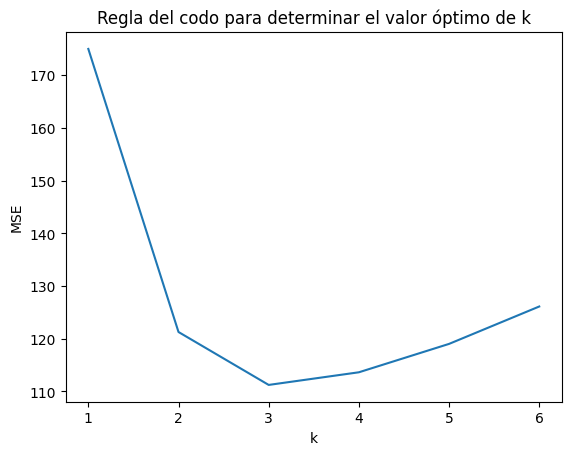

In [51]:
# Lista para almacenar los valores de MSE (Error Cuadrático Medio)
mse = []

# Rango de k para probar
k_range = range(1, 7)

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # Realizamos la validación cruzada para obtener una medida más robusta del error
    """  estamos tomando el negativo de los valores devueltos para obtener el MSE real. 
         Luego, añadimos la media de estos valores a nuestra lista de MSE para cada valor de k (mse.append(scores.mean())).
    """
    scores = -cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse.append(scores.mean())
    print(f'scores = {scores}')
    
 
# Graficamos los valores 
plt.plot(k_range, mse)
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('Regla del codo para determinar el valor óptimo de k')
plt.show()

# Graficamos 

In [52]:
# Determinar el mejor valor de k
best_k = k_range[mse.index(min(mse))]
print(f'Mejor número K: {best_k}')

Mejor número K: 3


In [53]:
# Creamos el modelo KNN con el mejor valor de k
knn = KNeighborsRegressor(n_neighbors=best_k)

# Ajustamos el modelo a los datos sin valores nulos
knn.fit(X_train, y_train)

# Imputamos los valores faltantes en la columna 'Age'
imputed_ages = knn.predict(df_without_age)
df.loc[df['Age'].isna(), 'Age'] = imputed_ages


In [54]:
# La columna 'Embarked' tiene datos faltantes que vamos a sustituir por la moda
embarked_mode = df['Embarked'].mode()[0]
df['Embarked'].fillna(embarked_mode, inplace=True)

In [55]:
# Convertimos como índice PassengerId
df.set_index('PassengerId')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,Fare_normalized
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,Sin datos,1.0,Braund,-0.502445
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,2.0,Cumings,0.786845
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,Sin datos,1.0,Heikkinen,-0.488854
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,1.0,Futrelle,0.420730
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,Sin datos,1.0,Allen,-0.486337
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,Sin datos,1.0,Montvila,-0.386671
888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,1.0,Graham,-0.044381
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.666667,1,2,W./C. 6607,23.4500,Sin datos,1.0,Johnston,-0.176263


In [56]:
# Compruebo que mi dataframe ya no tiene datos nulos
print(pd.isnull(df).sum())

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin              0
Embarked           0
LastName           0
Fare_normalized    0
dtype: int64


# CON TODOS LOS DATOS LIMPIOS, LET´S GO!

********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

## Comencemos con curiosidades:


## 1.- NÚMERO DE SUPERVIVIENTES

#### El número de supervivientes real fue al rededor de los 700, pero trabajando sobre nuestro csv el número es de 342 

In [57]:
num_survivors = titanic_data['Survived'].sum()
print(f"1. Número de supervivientes: {num_survivors}")

1. Número de supervivientes: 342


## 2.- EDAD MÁXIMA Y MÍNIMA DE NUESTROS PASAJEROS

#### Sabemos que las edades de nuestros pasajeros estaban entre los 80 años que tenía Mr. Henry Wilson y que el más pequeño era tan solo un bebé menor de un año llamado  Assad Alexander. 

In [52]:
#Calculamos la edad máxima y la edad mínima de los pasajeros
edad_maxima = df['Age'].max()
edad_minima = df['Age'].min()

print(f"Edad máxima: {edad_maxima} años")
print(f"Edad mínima: {edad_minima} años")


# Encontrar el pasajero más mayor
pasajero_mas_viejo = df.loc[df['Age'].idxmax()]['Name']

# Encontrar el pasajero más joven
pasajero_mas_joven = df.loc[df['Age'].idxmin()]['Name']

print(f"El pasajero más mayor del Titanic era: {pasajero_mas_viejo}")
print(f"El pasajero más joven del Titanic era: {pasajero_mas_joven}")


Edad máxima: 80.0 años
Edad mínima: 0.42 años
El pasajero más mayor del Titanic era: Barkworth, Mr. Algernon Henry Wilson
El pasajero más joven del Titanic era: Thomas, Master. Assad Alexander


## 3.- PRECIO DE LOS BILLETES

#### El precio máximo que se pagó por el pasaje en el barco fue 512.32 $ mientras que nos encontramos que hay billetes a coste 0. No hay evidencia histórica o registros oficiales que indiquen que se regalasen billetes del Titanic de forma generalizada o que hubiera una política de otorgar billetes de manera gratuita. La mayoría de los pasajeros del Titanic compraron sus billetes y la tarifa variaba según la clase del alojamiento .Es posible que algunos pasajeros obtuvieran los billetes forma gratuita por motivos específicos, como parte de acuerdos comerciales, promociones, o por ser empleados de la naviera o afiliados a la misma. Sin embargo, no hay información concluyente sobre esta práctica

In [53]:
precio_minimo = df['Fare'].min()
precio_maximo = df['Fare'].max()

print(f"Precio mínimo del billete: {precio_minimo}")
print(f"Precio máximo del billete: {precio_maximo}")

Precio mínimo del billete: 0.0
Precio máximo del billete: 512.3292


## 4.-FAMILIAS QUE PERDIERON A TODOS SUS MIEMBROS

#### ¿Sabíais que, a pesar de todos los fallecidos, tan solo 2 familias perdieron a todos sus miembros?. El hecho de que solo haya dos familias en las que todos los miembros perdieron la vida podría sugerir que, en general, el hecho de viajar en un núcleo familiar pudo haber tenido cierta influencia en la probabilidad de supervivencia en el desastre del Titanic. Además, ambas familias viajaban con billete de 3ª clase. ¿Casualidad?....lo veremos más adelante.

In [54]:
# Creo una nueva columna 'Familia' que combine 'SibSp' y 'Parch' para identificar a los miembros de la misma familia
df['Familia'] = df['SibSp'] + df['Parch']

# Filtro solo las filas donde al menos un miembro de la familia no sobrevivió
familias_con_victimas = df[df.groupby('Familia')['Survived'].transform('max') == 0]

# Clases de pasajero de las familias con víctimas
clases_de_familias_con_victimas = familias_con_victimas.groupby('Familia')['Pclass'].unique()

# Imprimir el número de familias y las clases de pasajero de las familias afectadas
numero_de_familias_con_victimas = len(clases_de_familias_con_victimas)
print(f'Número de familias que perdieron a todos sus miembros: {numero_de_familias_con_victimas}')

print('\nClases de pasajero de las familias con víctimas:')
for familia, clases in clases_de_familias_con_victimas.items():
    print(f'Familia {familia}: {", ".join(map(str, clases))}')


Número de familias que perdieron a todos sus miembros: 2

Clases de pasajero de las familias con víctimas:
Familia 7: 3
Familia 10: 3


**********************************************************************************************************************************************************************************************************

***********************************************************************************************************************************************************************************************************

# ***COMENCEMOS CON EL ANÁLISIS***

## 1.- DISTRIBUCIÓN DE SUPERVIVENCIA POR GÉNERO

#### Aunque es de sobra conocida la historia y todos ya teníamos información al respecto sobre la diferencia de hombres y mujeres que sobrevivienron, con los datos en la mano, Analicemos en primer lugar la distribución de superviviencia por género. Los datos nos arrojan un 74,2% de mujeres frente a un 18.8% de hombres. 

In [55]:
# Creo dos series separadas para hombres y mujeres
survivors_by_sex_percentage = df.groupby('Sex')['Survived'].mean() * 100

# Renombro los índices para que coincidan con 'Female' y 'Male'
survivors_by_sex_percentage.index = ['Female', 'Male']

# Imprimir el porcentaje de supervivientes por sexo
print("Porcentaje de supervivientes por sexo:")
print(survivors_by_sex_percentage)

Porcentaje de supervivientes por sexo:
Female    74.203822
Male      18.890815
Name: Survived, dtype: float64


In [56]:
import plotly.express as px
import pandas as pd

# Survivors_by_sex_percentage es un DataFrame con 'Female' y 'Male' como índices y 'Survived' como columna
survivors_by_sex_percentage = pd.DataFrame({'Survived': [74.203822, 18.890815]}, index=['Female', 'Male'])

# Creao gráfico interactivo
fig = px.bar(survivors_by_sex_percentage, x=survivors_by_sex_percentage.index, y='Survived',
             labels={'Survived': 'Porcentaje de Supervivencia'},
             title='Porcentaje de Supervivientes por Género',
             color=survivors_by_sex_percentage.index)

# Personalizo diseño
fig.update_layout(xaxis_title='Género', yaxis_title='Porcentaje de Supervivencia')

# Mostrar gráfico
fig.show()


### Conclusión:

La discrepancia en las tasas de supervivencia por género sugiere que, durante el desastre del Titanic, podría haber habido una prioridad dada a las mujeres en términos de acceso a los botes salvavidas o evacuación. El gráfico refleja la posible implementación del principio de "Mujeres y niños primero", una práctica común en situaciones de emergencia para priorizar la seguridad de grupos más vulnerables.

***********************************************************************************************************************************************************************************************************

## 2.- RELACIÓN ENTRE SUPERVIVIENCIA Y CLASE DE BILLETE

#### Veamos qué relación hay entre los no supervivientes y la clase de su billete.


In [65]:
import plotly.express as px


# Etiquetas para la leyenda
legend_labels = {0: 'No Sobrevivió', 1: 'Sobrevivió'}
pclass_labels = {1: '1ª Clase', 2: '2ª Clase', 3: '3ª Clase'}

# Creo un gráfico interactivo con Plotly Express
fig = px.bar(df, x='Pclass', color='Survived', barmode='stack',
             labels={'Survived': 'Estado de supervivencia', 'Pclass': 'Clase de billete'},
             category_orders={'Pclass': [1, 2, 3]},
             color_discrete_map={0: 'purple', 1: 'turquoise'})

# Añado leyenda
fig.update_layout(legend_title_text='Survived', legend=dict(traceorder='normal'))

# Personalizo el gráfico
fig.update_layout(title='Relación entre muertos y supervivientes por clase de billete',
                  xaxis_title='Clase de billete', yaxis_title='Número de pasajeros')

# Mostramos el gráfico interactivo
fig.show()


### Conclusión:

En el gráfico de barras, la clase de billete (1ª, 2ª o 3ª clase) se representa en el eje horizontal. Cada barra se divide por colores, donde el púrpura indica la cantidad de pasajeros que no sobrevivieron y el amarillo representa a los supervivientes. 

Se observa claramente que la 1ª clase tiene una proporción más alta de supervivientes, mientras que la 3ª clase tiene una proporción más baja, evidenciando la relación inversa entre la clase de billete y las tasas de supervivencia en el desastre del Titanic. Este patrón sugiere que, en general, las personas de primera clase tenían mayores probabilidades de sobrevivir.

**************************************************************************

## 3.- RELACIÓN ENTRE SUPERVIVIENCIA CON LA EDAD, PRECIO DEL BILLETE, CLASE SOCIAL Y GÉNERO

####  Veamos qué relación hubo entre los supervivientes en este caso por edad, precio del billete , clase social y género.
#### Para ello he cogido un conjunto de datos más pequeño para presentar un ejemplo visualmente más comprensible,  permitiendo de esta forma poder destacar patrones generales y simplificando así la comprensión de la relación entre las variables.

In [64]:
# Creo un DataFrame de ejemplo con un nombre diferente
df_ejemplo = pd.DataFrame({
    'Sex': ['Female', 'Male', 'Female', 'Male', 'Female', 'Male'],
    'Pclass': [1, 2, 3, 1, 2, 3],
    'Age': [25, 30, 22, 40, 35, 28],
    'Fare': [80, 50, 20, 120, 30, 15],
    'Survived': [1, 0, 1, 1, 0, 1]
})

# Mapeo el género a valores numéricos
df_ejemplo['Sex'] = df_ejemplo['Sex'].map({'Female': 0, 'Male': 1})

# Agrego una nueva columna 'Gender' con etiquetas 'Female' y 'Male'
df_ejemplo['Gender'] = df_ejemplo['Sex'].map({0: 'Female', 1: 'Male'})

# Creo la gráfica de dispersión tridimensional
fig = px.scatter_3d(df_ejemplo, x='Age', y='Fare', z='Pclass', color='Survived', symbol='Gender',
                    size_max=10, opacity=0.7, title='Relación entre supervivencia, género, clase, edad y precio del billete')

# Configuro el estilo del título
fig.update_layout(title=dict(text='Relación entre supervivencia, género, clase, edad y precio del billete',
                             font=dict(color='purple', size=20)))

# Coloco la leyenda en la esquina superior izquierda
fig.update_layout(legend=dict(x=0, y=1, traceorder='normal'))

# Mostrar la gráfica
fig.show()


### Conclusión:

Esta gráfica tridimensional revela patrones distintivos en la distribución de supervivientes en función de la edad, precio del billete, clase y género. Se destaca una mayor concentración de supervivientes en la primera clase y entre las mujeres, sugiriendo la posible implementación de la política de evacuación "comentada anteriormente" y la prioridad otorgada a los pasajeros de primera clase. Además, se evidencia que los pasajeros más jóvenes y aquellos con billetes más caros exhiben una mayor probabilidad de supervivencia.  Es crucial tener en cuenta que se basan en un conjunto de datos de ejemplo y no abarcan completamente la diversidad del conjunto de datos original del Titanic, que podría contener variaciones y matices adicionales.

## 4.- EL DESTINO FINAL DE LOS PASAJEROS EN FUNCIÓN DEL PUERTO DE EMBARQUE

#### En el contexto social y económico de 1912 , los puertos de Queenstown, Southampton y Cherbourg representaban diferentes realidades socioeconómicas. Southampton, como puerto principal de salida, estaba vinculado a una ciudad industrial y tenía una población diversa, con una mezcla de clases sociales. Cherbourg, ubicado en Francia, era conocido por atraer a pasajeros adinerados, dada su reputación como destino turístico de la alta sociedad. Queenstown (hoy Cobh), en Irlanda, servía como puerto de escala y tenía una población predominantemente más modesta, con mucha tasa de inmigración hacia América para buscar nuevas oportunidades.

In [61]:
# Filtro para obtener solo los registros de pasajeros que sobrevivieron y no supervivieron
supervivieron = df[df['Survived'] == 1].copy()
no_supervivieron = df[df['Survived'] == 0].copy()

# Mapeo de códigos de puerto a nombres completos para supervivientes y no supervivientes
puerto_mapping = {0: 'Queenstown', 1: 'Southampton', 2: 'Cherbourg'}
supervivieron['Embarked'] = supervivieron['Embarked'].map(puerto_mapping)
no_supervivieron['Embarked'] = no_supervivieron['Embarked'].map(puerto_mapping)

# Concateno ambos conjuntos de datos para tener uno que incluya supervivientes y no supervivientes
df_combined = pd.concat([supervivieron, no_supervivieron])

# Crea el gráfico interactivo con Plotly Express
fig = px.sunburst(df_combined, path=['Survived', 'Embarked', 'Pclass'], 
                  title='Relación entre supervivientes, puerto de embarque y clase de billete en el Titanic',
                  color='Pclass', color_continuous_scale='viridis',
                  labels={'Embarked': 'Puerto de Embarque', 'Pclass': 'Clase de Billete', 'Survived': 'Sobrevivencia'},
                  values='Pclass',  # Utilizar 'Pclass' en lugar de 'count'
                  hover_data={'Pclass': True, 'Embarked': True, 'Survived': True})

# Configuro el diseño del gráfico con un fondo oscuro
fig.update_layout(title_text='Relación entre supervivientes, puerto de embarque y clase de billete en el Titanic',
                  paper_bgcolor='rgb(17, 17, 17)',  # Fondo oscuro
                  plot_bgcolor='rgb(17, 17, 17)',   # Fondo oscuro
                  font_color='white')  # Texto en blanco

# Mostrar el gráfico interactivo
fig.show()


### Conclusión: 

Se observa que la proporción de supervivientes varía significativamente entre los puertos de embarque. Por ejemplo, en Southampton, el puerto principal de salida, la mayoría de los pasajeros no sobrevivieron, lo que puede indicar condiciones desfavorables durante la evacuación. En Cherbourg, que atraía a pasajeros adinerados, la proporción de supervivientes es relativamente más alta, sugiriendo posiblemente mejores condiciones de evacuación para la clase alta. Queenstown presenta una proporción intermedia.

******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

### CONCLUSIÓN FINAL DEL DATASET Y SUS CONSECUENCIAS

El análisis del dataset del Titanic revela patrones significativos en la supervivencia de los pasajeros, destacando la influencia de variables como el género, la clase de billete y el puerto de embarque entre otros. La información sugiere que la posición socioeconómica tenía un impacto crucial en las posibilidades de supervivencia. En el mundo real, esto subraya las desigualdades inherentes en situaciones de crisis, donde la posición financiera puede ser determinante para la supervivencia. Estos hallazgos plantean importantes reflexiones sobre la equidad y la toma de decisiones en contextos de emergencia, destacando la necesidad de considerar factores 